# Цель лабораторной работы 5


Изучение ансамблей моделей машинного обучения

# Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков. 
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую. 
4. Обучите следующие ансамблевые модели:
    - одну из моделей группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);
    - одну из моделей группы бустинга;
    - одну из моделей группы стекинга.
5. **(+1 балл на экзамене)** Дополнительно к указанным моделям обучите еще две модели:
    - Модель [многослойного персептрона.](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) По желанию, вместо библиотеки scikit-learn возможно использование библиотек [TensorFlow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/) или других аналогичных библиотек. 
    - Модель МГУА с использованием библиотеки - https://github.com/kvoyager/GmdhPy (или аналогичных библиотек). Найдите такие параметры запуска модели, при которых она будет по крайней мере не хуже, чем одна из предыдущих ансамблевых моделей.
6. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

# Ход лабораторной работы

## Текстовое описание набора данных

В качестве набора данных используется dataset рейтингов университетов мира на основании трёх рейтингов. Датасет доступен по адресу: https://www.kaggle.com/mylesoneill/world-university-rankings

Из набора данных будет рассматриваться только файл `cwurData.csv`.

Описание столбцов:
* `world_rank` - мировой рейтинг университета
* `institution` - название университета
* `country` - страна, в которой расположен университет
* `national_rank` - рейтинг университета в стране его нахождения
* `quality_of_education` - рейтинг качества образования
* `quality_of_faculty` - рейтинг качества профессорско-преподавательского состава
* `publications` - рейтинг публикаций
* `infuence` - рейтинг влияния
* `citations` - количество студентов в университете
* `broad_impact` - рейтинг за широкое влияние (предоставлен только за 2014 и 2015 гг. Остальное - пропуски)
* `patents` - рейтинг за патенты
* `score` - общий балл, используемый для определения мирового рейтинга
* `year` - год рейтинга (с 2012 по 2015 год)

## Основные характеристики набора данных

Подключаем все необходимые библиотеки

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline 
sns.set(style="ticks")
from io import StringIO
from IPython.display import Image
import graphviz
import pydotplus
from sklearn.metrics import mean_absolute_error

ModuleNotFoundError: No module named 'graphviz'

Подключаем Dataset

In [55]:
data = pd.read_csv('cwurData.csv', sep=",")

Размер набора данных

In [56]:
data.shape

(2200, 14)

Типы колонок

In [57]:
data.dtypes

world_rank                int64
institution              object
country                  object
national_rank             int64
quality_of_education      int64
alumni_employment         int64
quality_of_faculty        int64
publications              int64
influence                 int64
citations                 int64
broad_impact            float64
patents                   int64
score                   float64
year                      int64
dtype: object

Проверяем, есть ли пропущенные значения

In [58]:
data.isnull().sum()

world_rank                0
institution               0
country                   0
national_rank             0
quality_of_education      0
alumni_employment         0
quality_of_faculty        0
publications              0
influence                 0
citations                 0
broad_impact            200
patents                   0
score                     0
year                      0
dtype: int64

Первые 5 строк датасета

In [59]:
data.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012


In [60]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 2200


Процент пропусков в `broad_impact`

In [61]:
(200 / 2200) * 100

9.090909090909092

Настройка отображения графиков

In [62]:
# Задание формата графиков для сохранения высокого качества PNG
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
# Задание ширины графиков, чтобы они помещались на A4
pd.set_option("display.width", 70)

## Обработка пропусков данных

### Очистка строк

Можно очистить строки, содержащие пропуски. При этом останутся данные только за 2014 и 2015 гг (см. описание датасета)

In [63]:
# Удаление строк, содержащих пустые значения
data_no_null = data.dropna(axis=0, how='any')
(data.shape, data_no_null.shape)

((2200, 14), (2000, 14))

Выведем первые 11 строк, чтобы убедиться, что данные в `national_rank` числовые (Jupyter Lab в предпросмотре CSV показывает не совсем верно)

In [64]:
data_no_null.head(11)

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
200,1,Harvard University,USA,1,1,1,1,1,1,1,1.0,2,100.00,2014
201,2,Stanford University,USA,2,11,2,4,5,3,3,4.0,6,99.09,2014
202,3,Massachusetts Institute of Technology,USA,3,3,11,2,15,2,2,2.0,1,98.69,2014
203,4,University of Cambridge,United Kingdom,1,2,10,5,10,9,12,13.0,48,97.64,2014
204,5,University of Oxford,United Kingdom,2,7,12,10,11,12,11,12.0,16,97.51,2014
205,6,Columbia University,USA,4,13,8,9,14,13,9,13.0,4,97.41,2014
206,7,"University of California, Berkeley",USA,5,4,22,6,7,4,3,7.0,28,92.84,2014
207,8,University of Chicago,USA,6,10,14,8,17,19,10,18.0,149,92.03,2014
208,9,Princeton University,USA,7,5,16,3,70,25,19,41.0,204,88.56,2014
209,10,Yale University,USA,8,9,25,11,18,7,32,19.0,45,88.11,2014


In [65]:
total_count = data_no_null.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 2000


## Кодирование категориальных признаков

Преобразуем названия стран, городов, ... в числовые зеачения (label encoding)

In [66]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [67]:
le = LabelEncoder()
    # "institution"
le.fit(data_no_null.institution.drop_duplicates()) 
data_no_null.institution = le.transform(data_no_null.institution)
    # "country"
le.fit(data_no_null["country"].drop_duplicates()) 
data_no_null["country"] = le.transform(data_no_null["country"])

C:\Users\ARSQy\AppData\Local\Temp\ipykernel_14136\4210865855.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_null.institution = le.transform(data_no_null.institution)
C:\Users\ARSQy\AppData\Local\Temp\ipykernel_14136\4210865855.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_null["country"] = le.transform(data_no_null["country"])


Построим кореляционную матрицу

<AxesSubplot:>

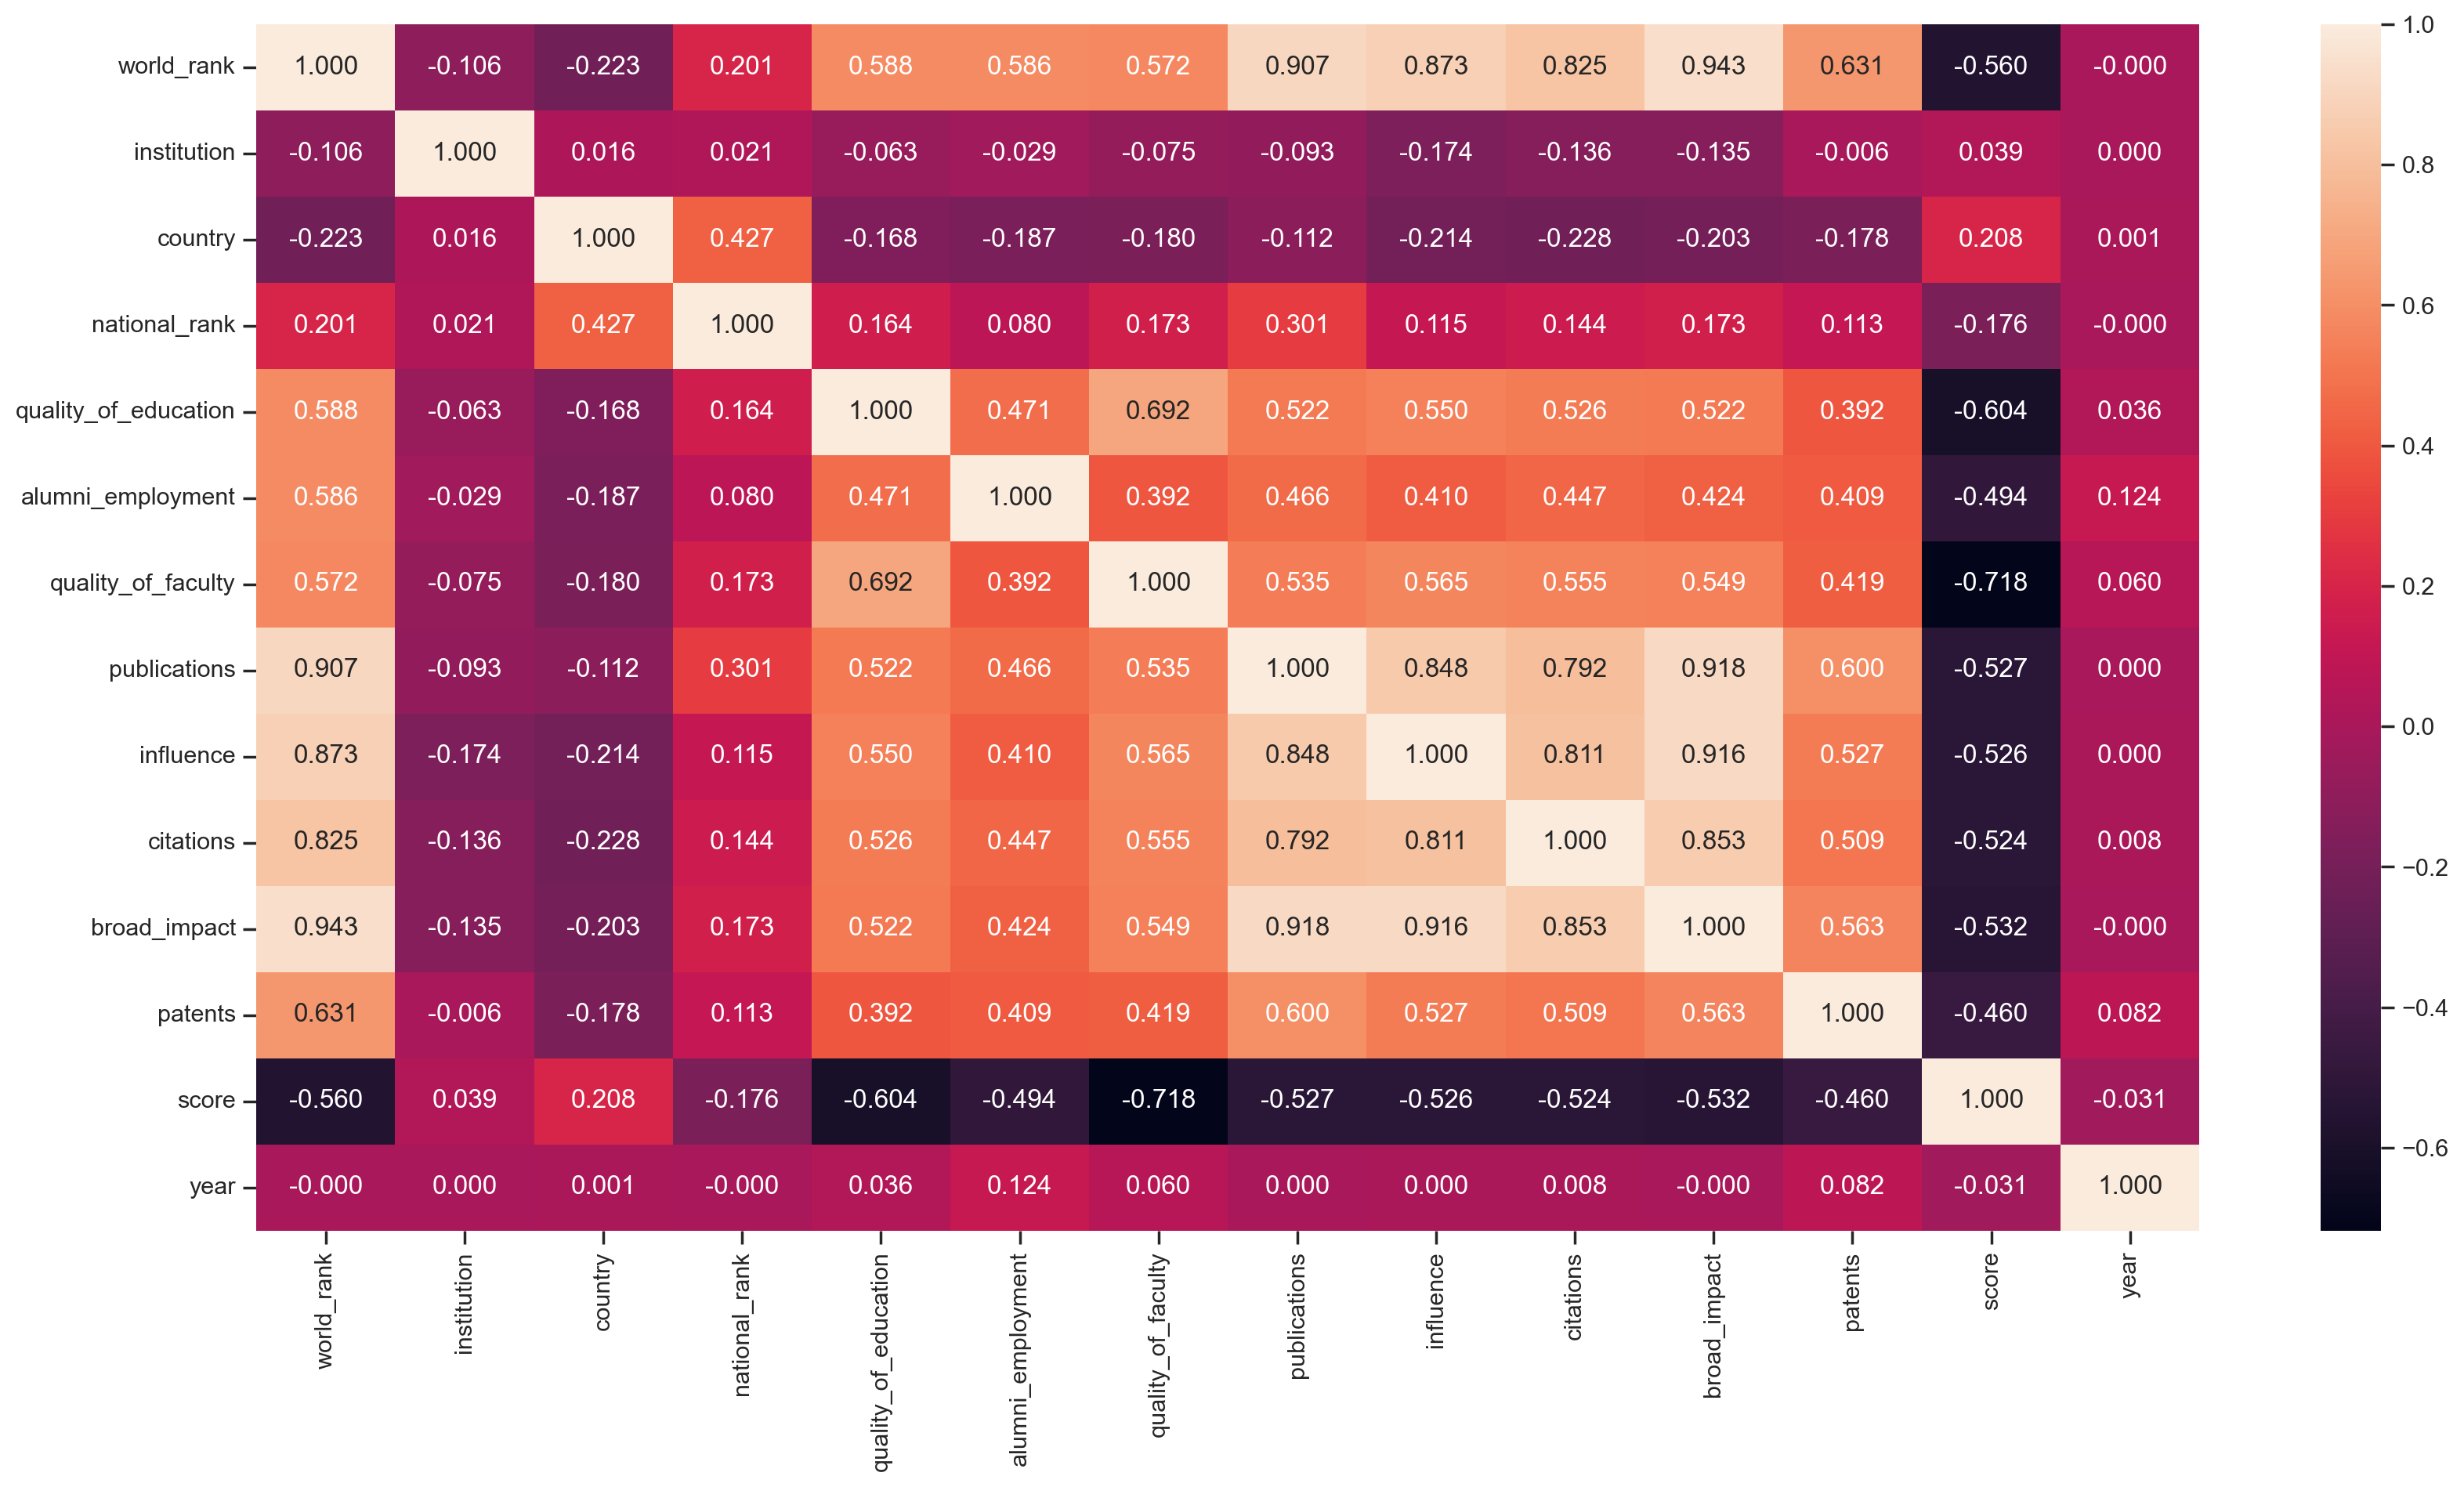

In [68]:
ig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data_no_null.corr(method='pearson'), ax=ax, annot=True, fmt='.3f')

## Предсказание целевого признака

Предскажем значение целевого признака `world_rank` по `broad_impact`, `influence` и `publications`, поскольку их значения кореляции ближе всего к 1

### Разбиение выборки на обучающую и тестовую

In [69]:
X = data_no_null[["broad_impact", "publications", "influence"]]
Y = data_no_null["world_rank"]
print('Входные данные:\n\n', X.head(), '\n\nВыходные данные:\n\n', Y.head())

Входные данные:

      broad_impact  publications  influence
200           1.0             1          1
201           4.0             5          3
202           2.0            15          2
203          13.0            10          9
204          12.0            11         12 

Выходные данные:

 200    1
201    2
202    3
203    4
204    5
Name: world_rank, dtype: int64


Разделим выборку на обучающую и тестовую

In [70]:
X_train,  X_test,  Y_train,  Y_test = train_test_split(X,  Y, random_state = 2022, test_size = 0.1)

Входные параметры обучающей выборки

In [71]:
X_train.head()

,broad_impact,publications,influence
2164,932.0,875,832
1710,590.0,576,792
428,164.0,200,149
1389,164.0,233,251
2089,932.0,675,775


Входные параметры тестовой выборки

In [72]:
X_test.head()

,broad_impact,publications,influence
1218,14.0,3,20
1495,265.0,236,235
843,703.0,943,599
2042,850.0,803,933
1869,606.0,701,658


Выходные параметры обучающей выборки

In [73]:
Y_train.head()

2164    965
1710    511
428     229
1389    190
2089    890
Name: world_rank, dtype: int64

Выходные параметры тестовой выборки

In [74]:
Y_test.head()

1218     19
1495    296
843     644
2042    843
1869    670
Name: world_rank, dtype: int64

### Построение модели сверхслучайных деревьев (группа бэггинга)

In [75]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

Обучим регрессор на 3 деревьях

In [76]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

In [77]:
tree1 = RandomForestRegressor(n_estimators=5, oob_score=True, random_state=2022)
tree1.fit(X, Y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=5, oob_score=True, random_state=2022)

Out-of-bag error, возвращаемый регрессором

In [78]:
tree1.oob_score_, 1-tree1.oob_score_

(0.4357507476207476, 0.5642492523792524)

In [79]:
tree1.oob_prediction_[55:70]

array([  0.        ,  18.33333333,  52.        ,  61.5       ,
        83.        ,  22.        , 100.5       ,  72.        ,
       157.        , 188.75      ,  75.        ,   0.        ,
        36.        ,  77.5       ,  68.        ])

Выведем полученные деревья

In [80]:
Image(get_png_tree(tree1.estimators_[0], X.columns[:3]), width="100%")

NameError: name 'pydotplus' is not defined

In [81]:
Image(get_png_tree(tree1.estimators_[1], X.columns[:3]), width="100%")

NameError: name 'pydotplus' is not defined

In [82]:
Image(get_png_tree(tree1.estimators_[2], X.columns[:3]), width="100%")

NameError: name 'pydotplus' is not defined

Посмотрим важность признаков в каждом из деревьев

In [83]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

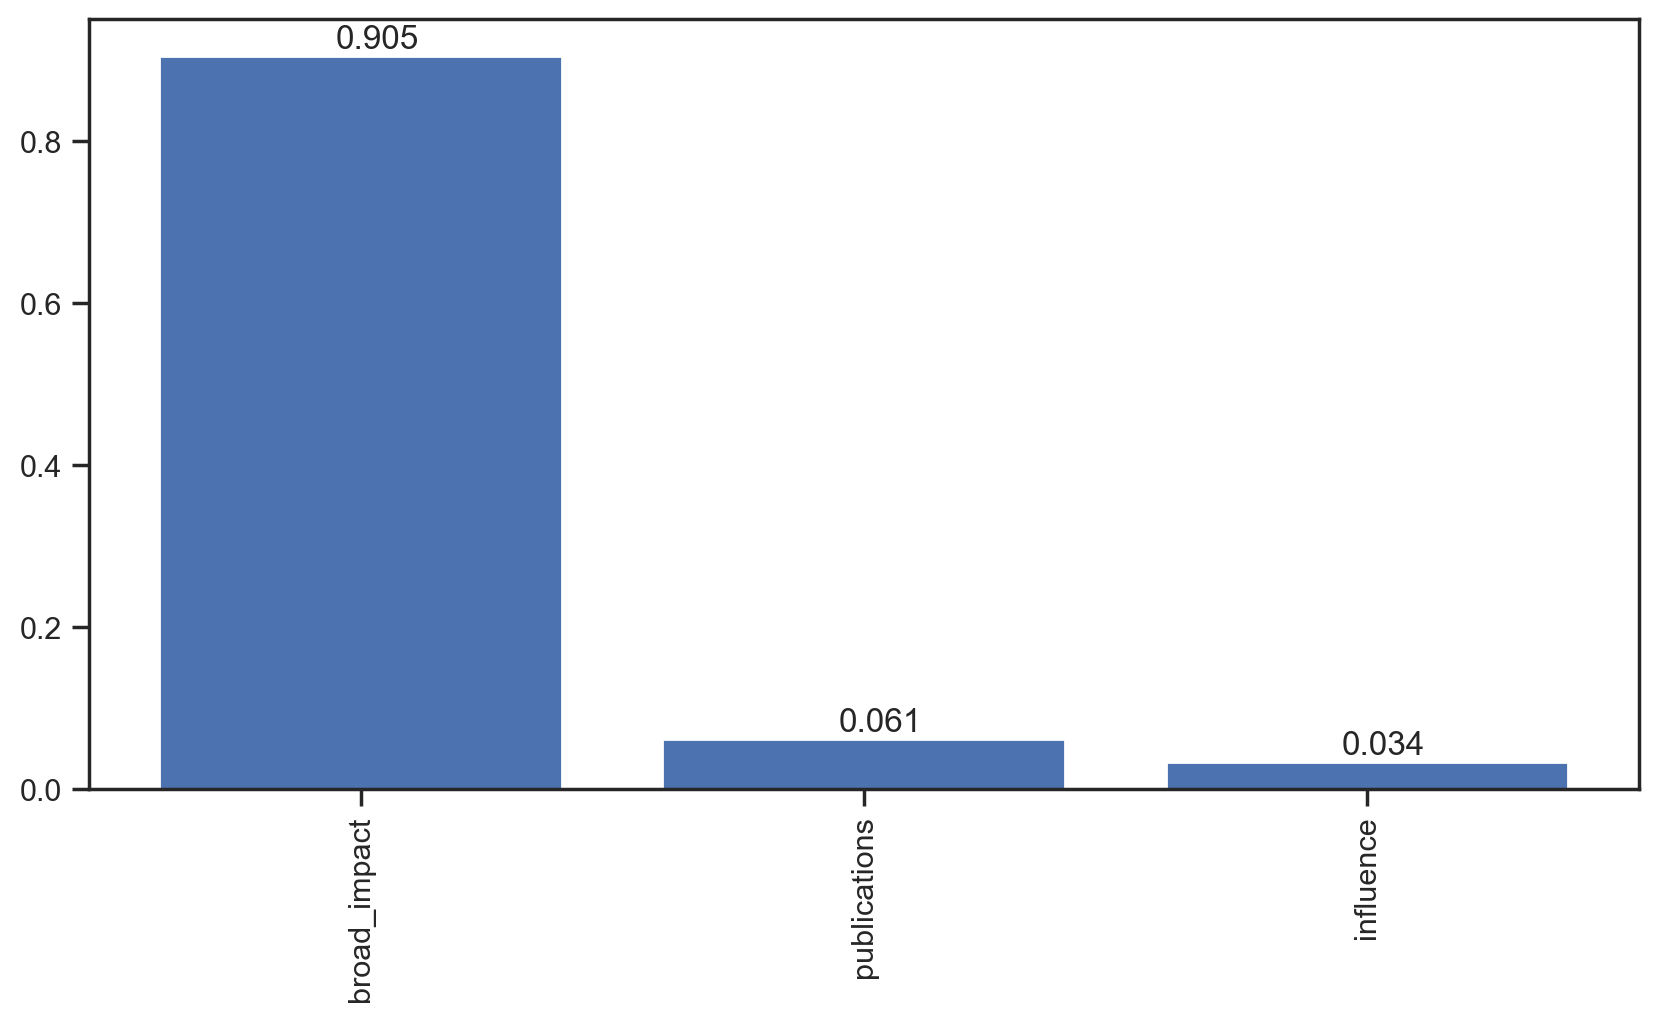

In [84]:
data_rf_reg = RandomForestRegressor(random_state=2022)
data_rf_reg.fit(X, Y)
_,_ = draw_feature_importances(data_rf_reg, X)

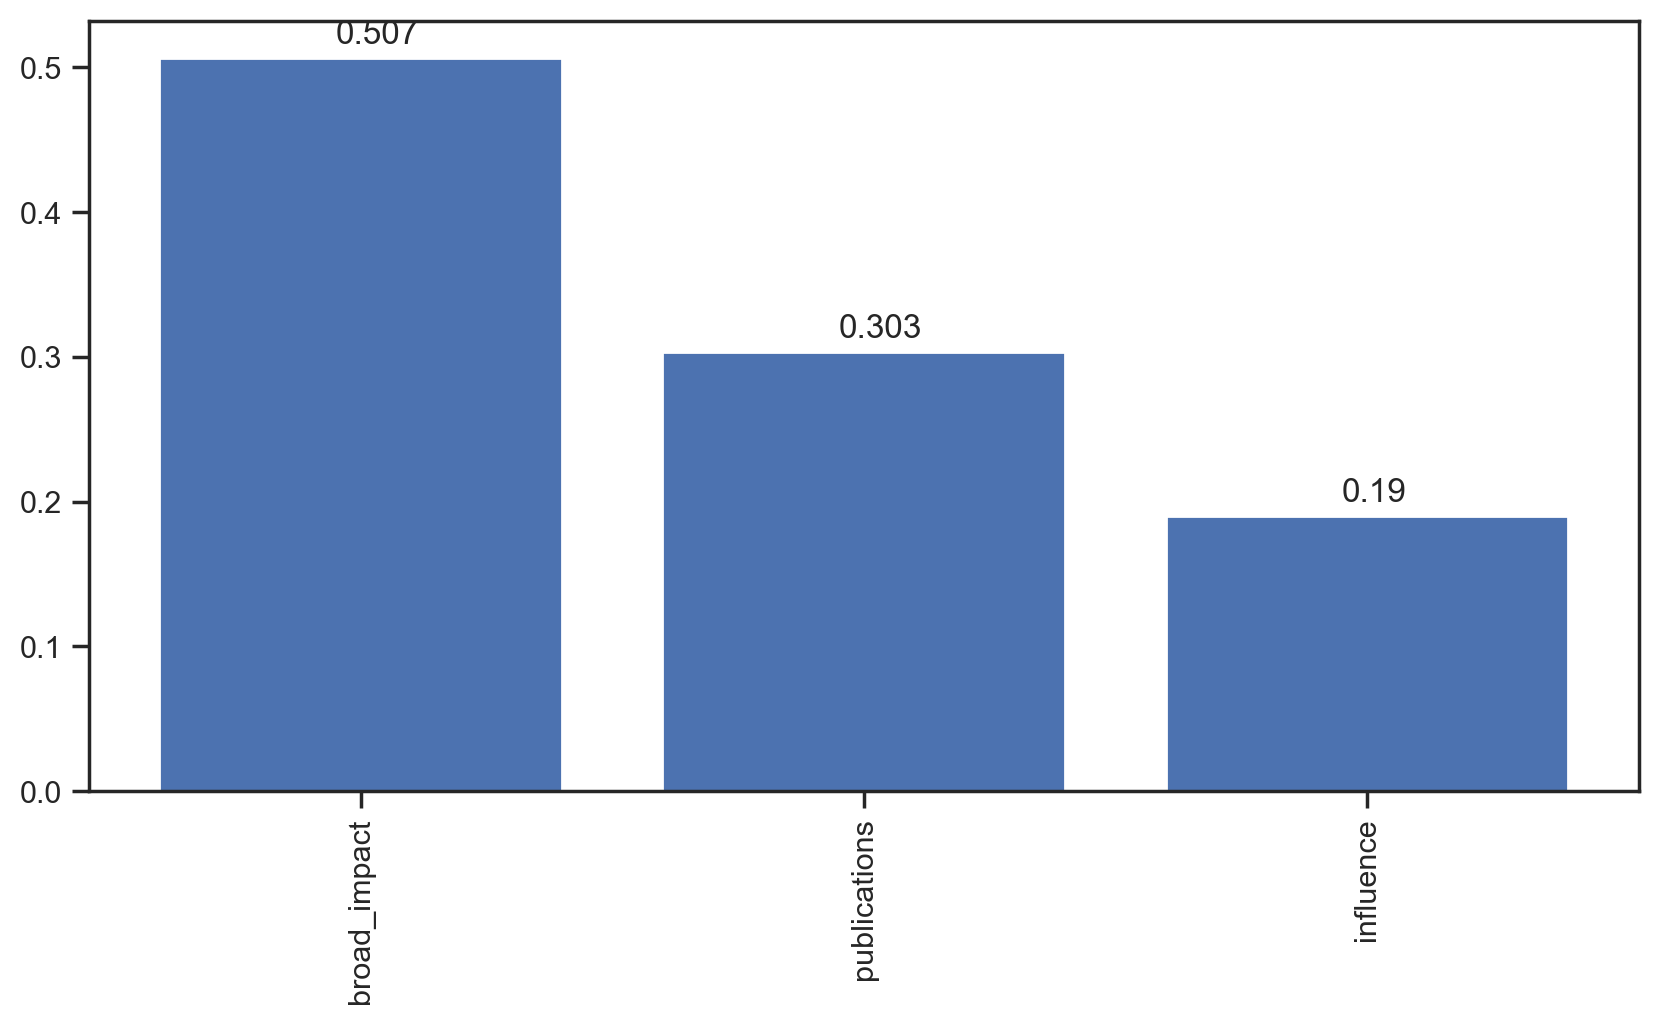

In [85]:
data_xtree_reg = ExtraTreesRegressor(random_state=2022)
data_xtree_reg.fit(X, Y)
_, _ = draw_feature_importances(data_xtree_reg, X)

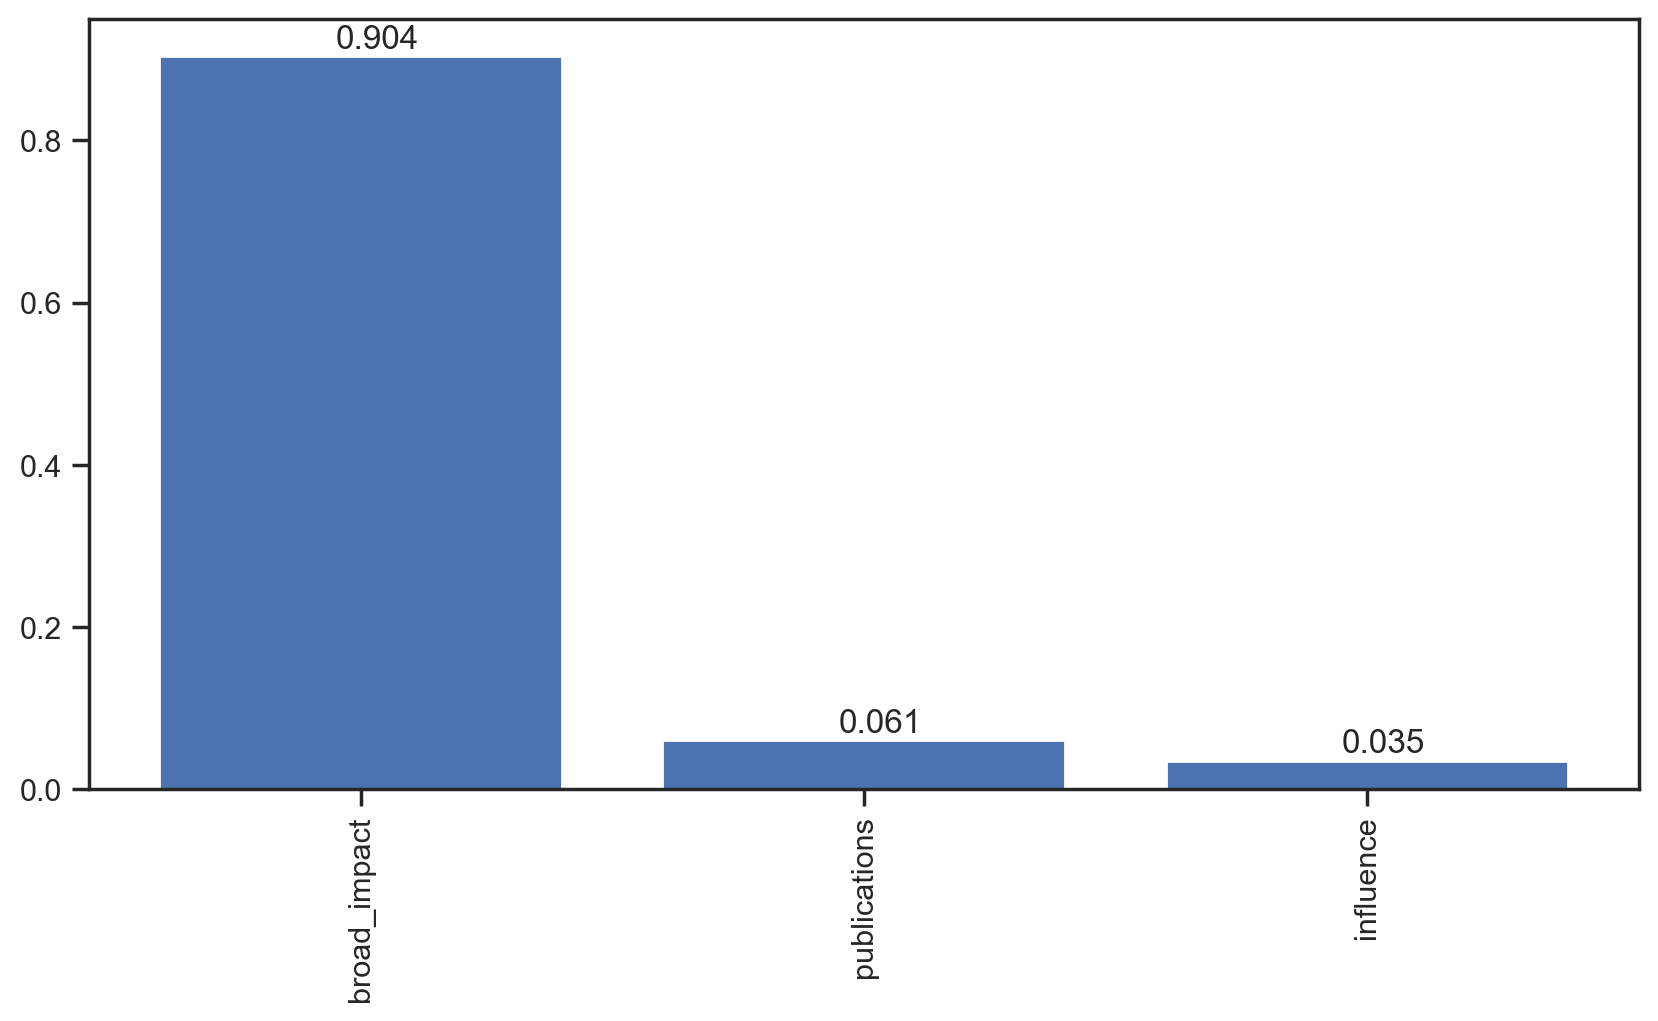

In [86]:
data_tree_reg = DecisionTreeRegressor(random_state=2022)
data_tree_reg.fit(X, Y)
_,_ = draw_feature_importances(data_tree_reg, X)

In [87]:
y_pred1 = tree1.predict(X_test)

In [88]:
print('Средняя абсолютная ошибка:',   mean_absolute_error(Y_test, y_pred1))

NameError: name 'mean_absolute_error' is not defined

### AdaBoost (бустинг)

In [89]:
from sklearn.ensemble import AdaBoostRegressor

Обучим регрессор на 3 деревьях

In [90]:
ab1 = AdaBoostRegressor(n_estimators=3, random_state=2022)
ab1.fit(X, Y)

AdaBoostRegressor(n_estimators=3, random_state=2022)

Выведем используемые деревья

In [91]:
Image(get_png_tree(ab1.estimators_[0], X.columns[:3]), width='40%')

NameError: name 'pydotplus' is not defined

In [92]:
Image(get_png_tree(ab1.estimators_[1], X.columns[:3]), width='40%')

NameError: name 'pydotplus' is not defined

In [93]:
Image(get_png_tree(ab1.estimators_[2], X.columns[:3]), width='40%')

NameError: name 'pydotplus' is not defined

Получим веса деревьев в ансамбле

In [94]:
ab1.estimator_weights_

array([2.236239  , 1.77461772, 1.20861837])

Проверим важность признаков в модели

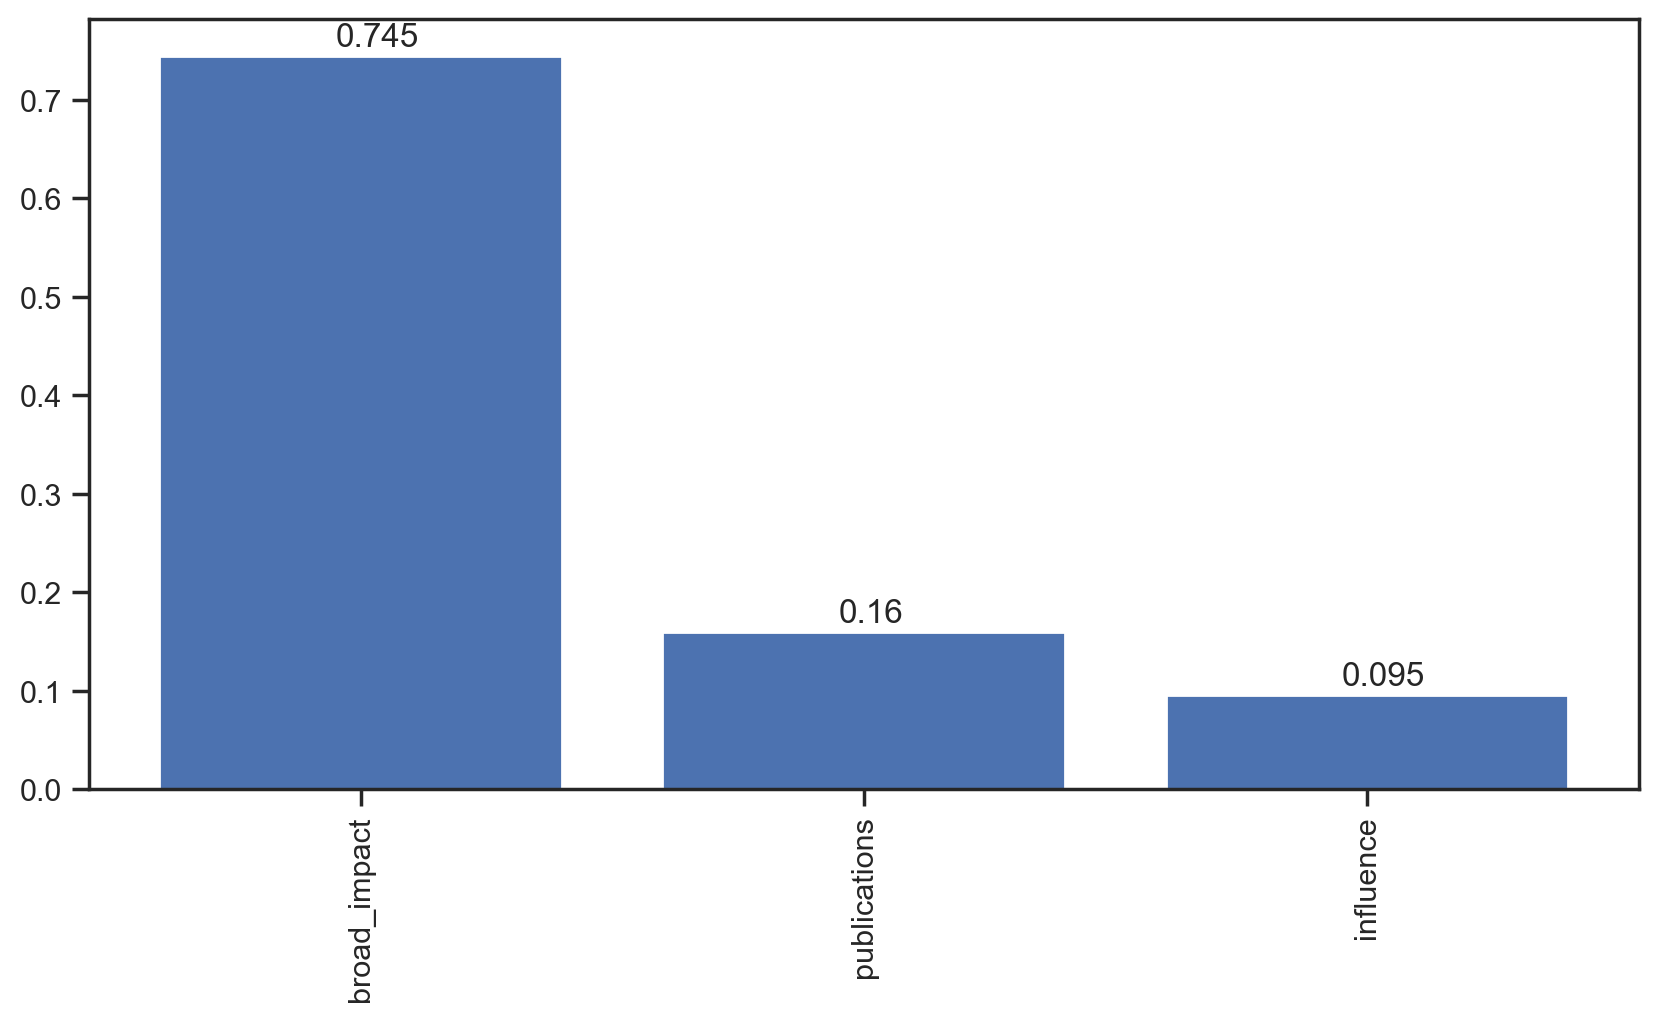

In [95]:
ab2 = AdaBoostRegressor(random_state=2022)
ab2.fit(X, Y)
_,_ = draw_feature_importances(ab2, X)

In [96]:
y_pred2 = ab1.predict(X_test)

In [97]:
print('Средняя абсолютная ошибка:',   mean_absolute_error(Y_test, y_pred2))

NameError: name 'mean_absolute_error' is not defined

### Стекинг

In [41]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

ModuleNotFoundError: No module named 'heamy'

In [42]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    result = mean_absolute_error(Y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))

Проверим точность на отдельных моделях

In [43]:
from sklearn.linear_model import LinearRegression

In [44]:
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

NameError: name 'mean_absolute_error' is not defined

In [45]:
dataset = Dataset(X_train, Y_train, X_test)

NameError: name 'Dataset' is not defined

С использованием библиотеки `heamy` сделаем стек из трёх уровней

In [46]:
# Первый уровень - две модели: дерево и линейная регрессия
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

NameError: name 'Regressor' is not defined

In [47]:
pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=3, seed=1)
# модель второго уровня - линейная регрессия
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=3,scorer=mean_absolute_error)

NameError: name 'ModelsPipeline' is not defined

## Выводы

Лучшей оказалась модель случайного леса со средней абсолютной ошибкой 24%